This notebook tests the maximum WTA problem size that can be computed in five minutes on this machine. The problem size in three scenarios is increased until the computation time exceeds five minutes.

We then plot the results.

In [1]:
# %load wta.py
import cvxpy as cp
import numpy as np
from microbench import MicroBench
basic_bench = MicroBench()
from time import time 
np.random.seed(1)

@basic_bench
def solve_wta(q, V, W, integer=True, lasso=False, verbose=False):
    """
    Solve the weapon-target assignment problem.
    Inputs:
        q: (n,m) array of survival probabilities
        V: (n,) array of target values
        W: (m,) array of weapon counts
        integer: boolean, whether to solve the integer or continuous problem
        lasso: boolean, whether to solve the lasso problem
    """
    if len(q.shape) == 1:
        n = q.shape[0]
        m = 1
        q = q.reshape((n,m))
    else:
        n, m = q.shape

    # Define the CVXPY problem.
    if integer:
        x = cp.Variable((n,m), integer=True)
    else:
        x = cp.Variable((n,m))
    weighted_weapons = cp.multiply(x, np.log(q)) # (n,m)
    survival_probs = cp.exp(cp.sum(weighted_weapons, axis=1)) # (n,)
    
    if lasso:
        v = 0.1*min(V)
        obj_fun = V@survival_probs + v*cp.sum(x)
    else:
        obj_fun = V@survival_probs
    objective = cp.Minimize(obj_fun)
    cons = [cp.sum(x, axis=0) <= W, x >= 0]

    # Solve
    prob = cp.Problem(objective, cons)

    # Use mosek timelimit
    prob.solve(solver=cp.MOSEK, 
               mosek_params={'MSK_DPAR_OPTIMIZER_MAX_TIME': 300.0}, 
               verbose=verbose)
    if prob.status != 'optimal':
        print(prob.status) 

    return prob.value, x.value

def get_final_surv_prob(q, x):
    """
    Get the final probability of kill for each target.
    Inputs:
        q: (n,m) array of survival probabilities
        x: (n,m) array of weapon assignments
    """
    return np.prod(np.power(q, x), axis=1)

def get_ind_value(q, V, W):
    """
    Get the total value if each platform solves independently.
    Inputs:
        q: (n,m) array of survival probabilities
        V: (n,) array of target values
        W: (m,) array of weapon counts
    """
    # Loop through platforms
    n, m = q.shape
    x = np.zeros((n,m))
    for i in range(m):
        # Solve the WTA problem for platform i
        q_i = q[:,i]
        pv, x_i = wta(q_i, V, W[i])
        x[:,i] = x_i[:,0]
    return V@get_final_surv_prob(q, x), x

def generate_random_problem(n=5, m=3):
    """
    Generate a random problem.
    Inputs:
        n: number of targets
        m: number of weapon types
    """
    #np.random.seed(1)
    q = np.random.rand(n,m)*.8 + .1 # Survival probability
    V = np.random.rand(n)*100 # Value of each target
    W = np.random.randint(1,10,m) # Number of weapons of each type
    return q, V, W

(CVXPY) Jan 15 01:29:36 PM: Encountered unexpected exception importing solver SCS:
ImportError('libmkl_rt.so.2: cannot open shared object file: No such file or directory')


In [2]:
# n = 10, m varies
max_t = 0
n = 10
m = 14
results = []
cutoff = 5*60

while max_t < cutoff:
    # Generate random problem
    for i in range(20):
        q, V, W = generate_random_problem(n, m)
        # tic
        t = time()
        #@basic_bench
        solve_wta(q, V, W)
        # toc
        t = time() - t
        max_t = max(max_t, t)
        print(n, m, t)
        results.append((n, m, i, t))
    m += 1


    

10 18 14.438550472259521
10 18 1.861443281173706
10 18 3.1891961097717285
10 18 90.56684970855713
10 18 7.27297306060791
10 18 18.820656776428223
10 18 2.8232028484344482
10 18 0.6065518856048584
10 18 4.37496280670166
10 18 2.1736927032470703
10 18 8.693520784378052
10 18 2.38218092918396
10 18 17.673832893371582
10 18 0.5005033016204834
10 18 8.379611015319824
10 18 2.2542545795440674
10 18 8.546262264251709
10 18 2.8700413703918457
10 18 1.4604620933532715
10 18 3.9942069053649902
10 19 6.0246312618255615
10 19 6.337499380111694
10 19 95.51823115348816
10 19 1.5293192863464355
10 19 43.41177463531494
10 19 236.3045036792755
10 19 4.540278673171997
10 19 33.13947796821594
10 19 1.3711295127868652
10 19 3.4669077396392822
10 19 51.0219829082489
10 19 2.3978044986724854
10 19 2.3333182334899902
10 19 5.162596702575684
10 19 3.6388540267944336
10 19 19.93424081802368
10 19 15.12359094619751
10 19 2.1216936111450195
10 19 19.383021116256714
10 19 116.55167508125305
10 20 3.84196066856384

/home/peter.barkley/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [3]:
# n varies, m = 10
t = 0
n = 14
m = 10

cutoff = 5*60
while t < cutoff:
    # Generate random problem
    for i in range(20):
        q, V, W = generate_random_problem(n, m)
        # tic
        t = time()
        #@basic_bench
        solve_wta(q, V, W)
        # toc
        t = time() - t
        print(n, m, t)
        results.append((n, m, i, t))
        if t > cutoff:
            break
    
    n += 1

    

print(n_results)

15 10 3.7793655395507812
15 10 4.810081481933594
15 10 1.2514452934265137
15 10 2.5284218788146973
15 10 2.5971972942352295
15 10 3.2801945209503174
15 10 3.0280370712280273
15 10 18.835376739501953
15 10 4.37881064414978
15 10 2.2834343910217285
15 10 6.650853157043457
15 10 10.11189866065979
15 10 23.669661283493042
15 10 3.437567949295044
15 10 2.4935779571533203
15 10 2.184021234512329
15 10 1.4853260517120361
15 10 6.587913274765015
15 10 17.308245420455933
15 10 6.953602075576782
optimal_inaccurate
16 10 300.06803250312805
[]


/home/peter.barkley/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [4]:
# n varies, m varies
max_t = 0
n = 11
m = 11
nm_results = []
cutoff = 5*60
while max_t < cutoff:
    # Generate random problem
    for i in range(20):
        q, V, W = generate_random_problem(n, m)
        # tic
        t = time()
        #@basic_bench
        solve_wta(q, V, W)
        # toc
        t = time() - t
        max_t = max(max_t, t)
        print(n, m, t)
        nm_results.append((n, m, i, t))
        
    m += 1
    if n == m:
        n += 1
    else:
        m += 1

    

print(nm_results)

11 11 5.144625663757324
11 11 1.3678984642028809
11 11 2.203239679336548
11 11 1.7334504127502441
11 11 4.586781740188599
11 11 1.7729465961456299
11 11 6.988020896911621
11 11 1.835832118988037
11 11 1.173698902130127
11 11 1.6087884902954102
11 11 1.0126874446868896
11 11 2.8104286193847656
11 11 2.6061923503875732
11 11 0.94584059715271
11 11 2.0566048622131348
11 11 3.0954365730285645
11 11 2.755319595336914
11 11 1.3392488956451416
11 11 0.7049596309661865
11 11 5.774441480636597
11 13 3.575690984725952
11 13 5.385692358016968
11 13 5.431390762329102
11 13 1.935051441192627
11 13 3.1139075756073
11 13 4.972979545593262
11 13 2.2710208892822266
11 13 1.0893595218658447
11 13 3.1344645023345947
11 13 1.6108064651489258
11 13 0.9629881381988525
11 13 2.8221323490142822
11 13 1.3552196025848389
11 13 4.357142925262451
11 13 1.0141968727111816
11 13 1.65480637550354
11 13 0.7605235576629639
11 13 2.8757853507995605
11 13 1.2791740894317627
11 13 3.428828716278076
11 15 1.66266083717346

In [6]:
print(m_results)

[(10, 18, 0, 14.438550472259521), (10, 18, 1, 1.861443281173706), (10, 18, 2, 3.1891961097717285), (10, 18, 3, 90.56684970855713), (10, 18, 4, 7.27297306060791), (10, 18, 5, 18.820656776428223), (10, 18, 6, 2.8232028484344482), (10, 18, 7, 0.6065518856048584), (10, 18, 8, 4.37496280670166), (10, 18, 9, 2.1736927032470703), (10, 18, 10, 8.693520784378052), (10, 18, 11, 2.38218092918396), (10, 18, 12, 17.673832893371582), (10, 18, 13, 0.5005033016204834), (10, 18, 14, 8.379611015319824), (10, 18, 15, 2.2542545795440674), (10, 18, 16, 8.546262264251709), (10, 18, 17, 2.8700413703918457), (10, 18, 18, 1.4604620933532715), (10, 18, 19, 3.9942069053649902), (10, 19, 0, 6.0246312618255615), (10, 19, 1, 6.337499380111694), (10, 19, 2, 95.51823115348816), (10, 19, 3, 1.5293192863464355), (10, 19, 4, 43.41177463531494), (10, 19, 5, 236.3045036792755), (10, 19, 6, 4.540278673171997), (10, 19, 7, 33.13947796821594), (10, 19, 8, 1.3711295127868652), (10, 19, 9, 3.4669077396392822), (10, 19, 10, 51.

      n   m  i           t  prob_size
0    10  18  0   14.438550        180
1    10  18  1    1.861443        180
2    10  18  2    3.189196        180
3    10  18  3   90.566850        180
4    10  18  4    7.272973        180
..   ..  .. ..         ...        ...
148  11  19  5   48.639918        209
149  11  19  6    1.676375        209
150  11  19  7    2.625754        209
151  11  19  8    6.563750        209
152  11  19  9  300.064942        209

[150 rows x 5 columns]


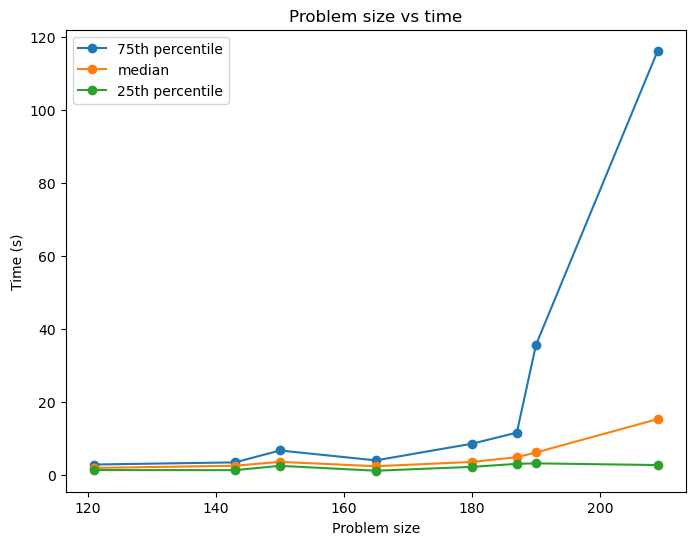

<Figure size 640x480 with 0 Axes>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(m_results, columns=['n', 'm', 'i', 't'])
df['t'] = df['t'].astype(float)

df['prob_size'] = df['n']*df['m']
df['prob_size'] = df['prob_size'].astype(int)

# Plot just problem size vs median time excluding groups with less than five data points
# Form subset of data with at least five data points
df_subset = df.groupby('prob_size').filter(lambda x: len(x) >= 5)
print(df_subset)

plt.figure(figsize=(8,6))
# Third quartile
plt.plot(df_subset.groupby('prob_size')['t'].quantile(.75), 'o-')
plt.plot(df_subset.groupby('prob_size')['t'].median(), 'o-')
plt.plot(df_subset.groupby('prob_size')['t'].quantile(.25), 'o-')
#plt.plot(df_subset.groupby('prob_size')['t'].median(), 'o-')
plt.xlabel('Problem size')
plt.ylabel('Time (s)')
plt.legend(['75th percentile', 'median', '25th percentile'])
plt.title('Problem size vs time')
plt.show()

# Save figure
plt.savefig('m_time.png')

In [9]:
# Show data with problem size 160
df[df['prob_size'] == 200]

,n,m,i,t,prob_size
40,10,20,0,3.841961,200
41,10,20,1,300.040927,200
